# GMM Clustering for Temperature Classification (3 Clusters: Hot, Cold, Normal)

This notebook implements Gaussian Mixture Model (GMM) clustering to classify sensor readings into three temperature states:
- **Cold**
- **Normal**
- **Hot**

## Data Structure
- Source: Balanced dataset (98,820 rows × 4 sensors)
- 6 temperature ranges × 10 readings per range × 1,647 rows per reading
- Features: sensor_1, sensor_2, sensor_3, sensor_4

## Objective
Train a 3-component GMM model to:
1. Learn the distribution of sensor readings in each temperature category
2. Classify new sensor readings into Hot, Cold, or Normal categories
3. Provide probability scores for each classification

## Step 1: Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load and Explore Balanced Dataset

In [2]:
# Load balanced dataset
balanced_data = pd.read_csv('balanced_dataset_combined.csv')

print("="*80)
print("BALANCED DATASET LOADED")
print("="*80)
print(f"Shape: {balanced_data.shape}")
print(f"Columns: {list(balanced_data.columns)}")
print(f"\nDataset info:")
print(balanced_data.info())
print(f"\nFirst few rows:")
print(balanced_data.head())

# Verify balanced structure
print(f"\n" + "="*80)
print("DATASET BALANCE VERIFICATION")
print("="*80)
temp_dist = balanced_data['temp_range'].value_counts().sort_index()
for temp_range, count in temp_dist.items():
    pct = count / len(balanced_data) * 100
    print(f"{temp_range}°C: {count:,} rows ({pct:.2f}%)")

print(f"\nTotal: {len(balanced_data):,} rows")

BALANCED DATASET LOADED
Shape: (98820, 10)
Columns: ['elapsed_time_s', 'clock_time', 'time_ms', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'temp_range', 'reading_num', 'file_id']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   elapsed_time_s  98820 non-null  float64
 1   clock_time      98820 non-null  object 
 2   time_ms         98820 non-null  int64  
 3   sensor_1        98820 non-null  int64  
 4   sensor_2        98820 non-null  int64  
 5   sensor_3        98820 non-null  int64  
 6   sensor_4        98820 non-null  int64  
 7   temp_range      98820 non-null  object 
 8   reading_num     98820 non-null  int64  
 9   file_id         98820 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 7.5+ MB
None

First few rows:
   elapsed_time_s clock_time  time_ms  sensor_1  sensor_2  sensor_3 

## Step 3: DATA EXTRACTION

In [3]:
# Extract sensor columns (raw data - no assumptions about temperature ranges)
sensor_columns = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']
X = balanced_data[sensor_columns].values

print("\n" + "="*80)
print("DATA EXTRACTION - RAW SENSOR DATA ONLY")
print("="*80)
print(f"Total samples: {len(X):,}")
print(f"Features: {sensor_columns}")
print(f"Data shape: {X.shape}")
print(f"\nBasic statistics (no assumptions):")
for i, col in enumerate(sensor_columns):
    print(f"  {col}: mean={X[:, i].mean():.2f}, std={X[:, i].std():.2f}, min={X[:, i].min():.2f}, max={X[:, i].max():.2f}")



DATA EXTRACTION - RAW SENSOR DATA ONLY
Total samples: 98,820
Features: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']
Data shape: (98820, 4)

Basic statistics (no assumptions):
  sensor_1: mean=130.93, std=44.43, min=32.00, max=296.00
  sensor_2: mean=416.77, std=50.41, min=201.00, max=682.00
  sensor_3: mean=675.63, std=181.80, min=317.00, max=1151.00
  sensor_4: mean=325.19, std=129.47, min=46.00, max=615.00


## Step 4: Data Preprocessing (Standardization)


In [4]:
# Standardize the raw sensor data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n" + "="*80)
print("DATA STANDARDIZATION")
print("="*80)
print("Applied StandardScaler (zero mean, unit variance)")
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled mean: {X_scaled.mean(axis=0).round(6)}")
print(f"Scaled std:  {X_scaled.std(axis=0).round(6)}")



DATA STANDARDIZATION
Applied StandardScaler (zero mean, unit variance)
Scaled data shape: (98820, 4)
Scaled mean: [-0.  0. -0.  0.]
Scaled std:  [1. 1. 1. 1.]


## Step 5: Fit GMM Model with 3 Clusters

In [5]:
# Fit GMM with 3 clusters using default initialization
n_clusters = 3
gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    random_state=42,
    n_init=20,
    max_iter=300
)

print("\n" + "="*80)
print("GAUSSIAN MIXTURE MODEL - 3 CLUSTERS")
print("="*80)
print(f"n_components: {n_clusters}")
print(f"covariance_type: full")
print(f"random_state: 42")
print("\nFitting model on raw sensor data...")
gmm.fit(X_scaled)

print(f"\n✓ Model fitted successfully!")
print(f"  Converged: {gmm.converged_}")
print(f"  Iterations: {gmm.n_iter_}")
print(f"  Log-likelihood: {gmm.score(X_scaled):.6f}")

# Get cluster assignments
clusters = gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)

print(f"\nCluster distribution:")
unique, counts = np.unique(clusters, return_counts=True)
for cluster_id, count in zip(unique, counts):
    pct = count / len(clusters) * 100
    print(f"  Cluster {cluster_id}: {count:,} samples ({pct:.2f}%)")



GAUSSIAN MIXTURE MODEL - 3 CLUSTERS
n_components: 3
covariance_type: full
random_state: 42

Fitting model on raw sensor data...

✓ Model fitted successfully!
  Converged: True
  Iterations: 7
  Log-likelihood: -0.739891

Cluster distribution:
  Cluster 0: 49,406 samples (50.00%)
  Cluster 1: 33,082 samples (33.48%)
  Cluster 2: 16,332 samples (16.53%)

✓ Model fitted successfully!
  Converged: True
  Iterations: 7
  Log-likelihood: -0.739891

Cluster distribution:
  Cluster 0: 49,406 samples (50.00%)
  Cluster 1: 33,082 samples (33.48%)
  Cluster 2: 16,332 samples (16.53%)


## Step 6: Cluster Analysis

In [6]:
# Analyze cluster characteristics (descriptive statistics only)
print("\n" + "="*80)
print("CLUSTER ANALYSIS - SENSOR CHARACTERISTICS")
print("="*80)

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    cluster_data = X[mask]
    
    print(f"\n--- Cluster {cluster_id} (n={mask.sum():,}) ---")
    for i, sensor in enumerate(sensor_columns):
        mean_val = cluster_data[:, i].mean()
        std_val = cluster_data[:, i].std()
        min_val = cluster_data[:, i].min()
        max_val = cluster_data[:, i].max()
        print(f"  {sensor}: mean={mean_val:.2f}, std={std_val:.2f}, range=[{min_val:.2f}, {max_val:.2f}]")



CLUSTER ANALYSIS - SENSOR CHARACTERISTICS

--- Cluster 0 (n=49,406) ---
  sensor_1: mean=169.25, std=24.77, range=[100.00, 296.00]
  sensor_2: mean=442.27, std=26.66, range=[254.00, 638.00]
  sensor_3: mean=500.66, std=25.69, range=[317.00, 664.00]
  sensor_4: mean=449.39, std=25.12, range=[255.00, 615.00]

--- Cluster 1 (n=33,082) ---
  sensor_1: mean=92.32, std=13.82, range=[37.00, 143.00]
  sensor_2: mean=366.25, std=34.73, range=[201.00, 475.00]
  sensor_3: mean=818.93, std=33.09, range=[639.00, 921.00]
  sensor_4: mean=179.42, std=30.60, range=[46.00, 277.00]

--- Cluster 2 (n=16,332) ---
  sensor_1: mean=93.23, std=28.63, range=[32.00, 257.00]
  sensor_2: mean=441.97, std=54.87, range=[250.00, 682.00]
  sensor_3: mean=914.67, std=66.51, range=[463.00, 1151.00]
  sensor_4: mean=244.75, std=37.91, range=[84.00, 374.00]


In [16]:
# Model evaluation metrics (no temperature ground truth)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(X_scaled, clusters)
db_index = davies_bouldin_score(X_scaled, clusters)
ch_index = calinski_harabasz_score(X_scaled, clusters)

print("\n" + "="*80)
print("CLUSTERING QUALITY METRICS")
print("="*80)
print(f"Silhouette Score:      {silhouette:.4f} {'(Good)' if silhouette > 0.5 else '(Fair)' if silhouette > 0.3 else '(Poor)'}")
print(f"Davies-Bouldin Index:  {db_index:.4f} {'(Good - lower is better)' if db_index < 1 else '(Acceptable)'}")
print(f"Calinski-Harabasz Idx: {ch_index:.2f} {'(Good - higher is better)' if ch_index > 100 else '(Acceptable)'}")

print(f"\nModel Information Criteria:")
print(f"  BIC: {gmm.bic(X_scaled):.2f}")
print(f"  AIC: {gmm.aic(X_scaled):.2f}")



CLUSTERING QUALITY METRICS
Silhouette Score:      0.5489 (Good)
Davies-Bouldin Index:  0.8953 (Good - lower is better)
Calinski-Harabasz Idx: 184282.55 (Good - higher is better)

Model Information Criteria:
  BIC: 146738.08
  AIC: 146320.03


## Step 6: Visualization


In [8]:
# PCA for 2D and 3D visualization
from sklearn.decomposition import PCA

# 2D PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 3D PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print("\n" + "="*80)
print("DIMENSIONALITY REDUCTION FOR VISUALIZATION")
print("="*80)
print(f"Original features: {X_scaled.shape[1]}")
print(f"\n2D PCA:")
print(f"  Variance explained: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca_2d.explained_variance_ratio_[0]:.2%}, PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"\n3D PCA:")
print(f"  Variance explained: {pca_3d.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca_3d.explained_variance_ratio_[0]:.2%}, PC2: {pca_3d.explained_variance_ratio_[1]:.2%}, PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")



DIMENSIONALITY REDUCTION FOR VISUALIZATION
Original features: 4

2D PCA:
  Variance explained: 94.74%
  PC1: 76.59%, PC2: 18.15%

3D PCA:
  Variance explained: 99.20%
  PC1: 76.59%, PC2: 18.15%, PC3: 4.46%


## Sensor Values by Cluster


✓ Saved: gmm_sensor_distributions.png


✓ Saved: gmm_sensor_distributions.png


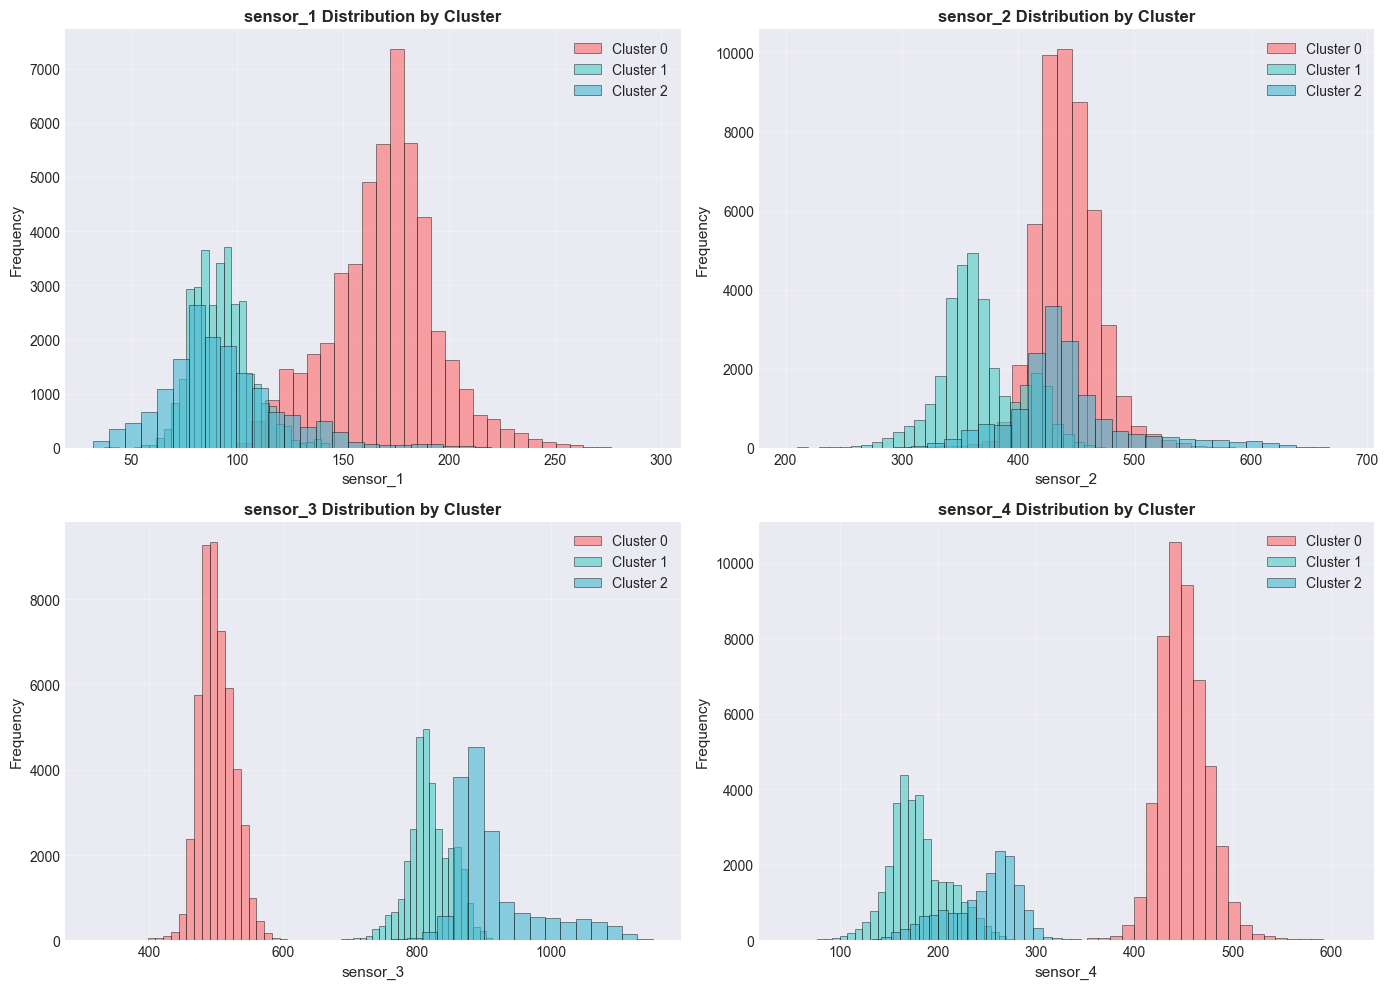

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, sensor in enumerate(sensor_columns):
    ax = axes[idx]
    sensor_idx = idx
    
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        cluster_values = X[mask, sensor_idx]
        ax.hist(cluster_values, bins=30, alpha=0.6, label=f'Cluster {cluster_id}', 
               color=colors[cluster_id], edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel(sensor, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{sensor} Distribution by Cluster', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_sensor_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gmm_sensor_distributions.png")
plt.show()


✓ Saved: gmm_clusters_3d_pca.png


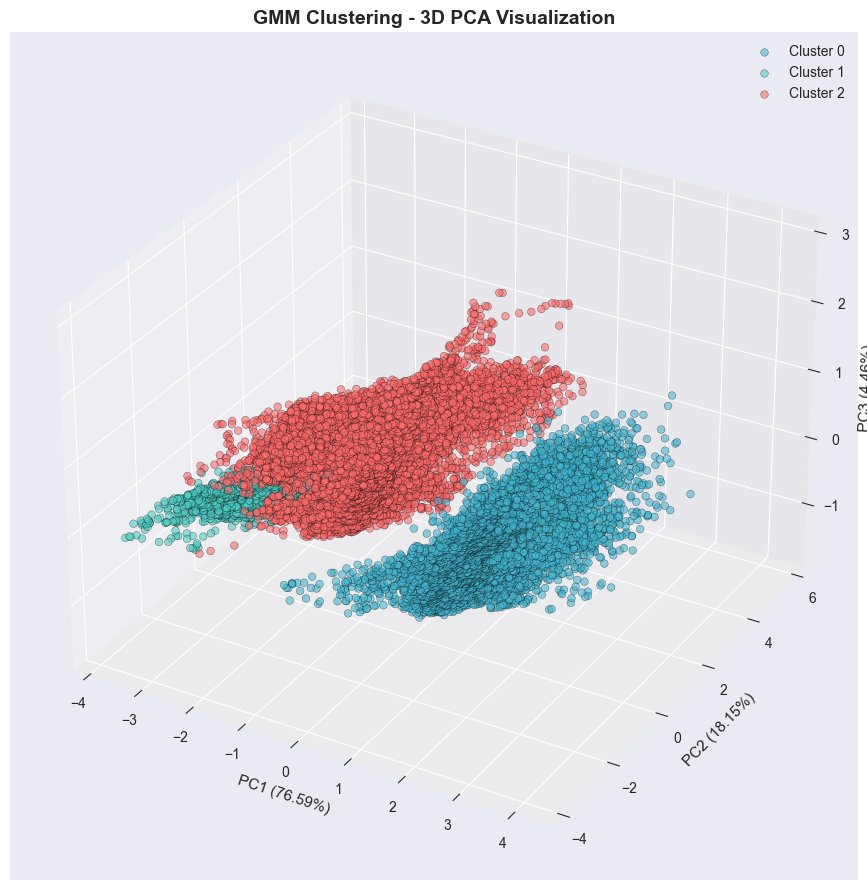

In [18]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

colors = ['#45B7D1', '#4ECDC4', '#FF6B6B']

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c=colors[cluster_id], label=f'Cluster {cluster_id}', 
              alpha=0.6, s=30, edgecolors='k', linewidth=0.3)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=11)
ax.set_title('GMM Clustering - 3D PCA Visualization', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('gmm_clusters_3d_pca.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gmm_clusters_3d_pca.png")
plt.show()


## Step 7: Save Results


In [12]:
# Save clustering results with probabilities
results_df = balanced_data[['temp_range']].copy()
results_df['cluster'] = clusters

# Add probability for each cluster
for i in range(n_clusters):
    results_df[f'prob_cluster_{i}'] = probs[:, i]

# Add maximum probability and confidence
results_df['max_probability'] = probs.max(axis=1)
results_df['confidence'] = (results_df['max_probability'] * 100).round(2)

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)
print(f"Results shape: {results_df.shape}")
print(f"\nFirst 5 rows:")
print(results_df.head())

results_file = 'gmm_clustering_results.csv'
results_df.to_csv(results_file, index=False)
print(f"\n✓ Saved: {results_file}")



SAVING RESULTS
Results shape: (98820, 7)

First 5 rows:
  temp_range  cluster  prob_cluster_0  prob_cluster_1  prob_cluster_2  \
0      20-30        0             1.0             0.0    2.120733e-20   
1      20-30        0             1.0             0.0    2.519451e-19   
2      20-30        0             1.0             0.0    1.481804e-17   
3      20-30        0             1.0             0.0    8.119507e-18   
4      20-30        0             1.0             0.0    2.484388e-19   

   max_probability  confidence  
0              1.0       100.0  
1              1.0       100.0  
2              1.0       100.0  
3              1.0       100.0  
4              1.0       100.0  

✓ Saved: gmm_clustering_results.csv

✓ Saved: gmm_clustering_results.csv


In [13]:
# Save model and preprocessor
import pickle

model_data = {
    'gmm_model': gmm,
    'scaler': scaler,
    'sensor_columns': sensor_columns,
    'n_clusters': n_clusters
}

model_file = 'gmm_model.pkl'
with open(model_file, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Saved: {model_file}")

# Save model statistics
stats = {
    'n_samples': len(X),
    'n_features': len(sensor_columns),
    'n_clusters': n_clusters,
    'converged': gmm.converged_,
    'n_iterations': gmm.n_iter_,
    'log_likelihood': float(gmm.score(X_scaled)),
    'silhouette_score': float(silhouette),
    'davies_bouldin_index': float(db_index),
    'calinski_harabasz_index': float(ch_index),
    'bic': float(gmm.bic(X_scaled)),
    'aic': float(gmm.aic(X_scaled))
}

stats_df = pd.DataFrame([stats])
stats_file = 'gmm_model_statistics.csv'
stats_df.to_csv(stats_file, index=False)

print(f"✓ Saved: {stats_file}")
print("\nModel Statistics:")
for key, val in stats.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.6f}")
    else:
        print(f"  {key}: {val}")


✓ Saved: gmm_model.pkl
✓ Saved: gmm_model_statistics.csv

Model Statistics:
  n_samples: 98820
  n_features: 4
  n_clusters: 3
  converged: True
  n_iterations: 7
  log_likelihood: -0.739891
  silhouette_score: 0.548918
  davies_bouldin_index: 0.895328
  calinski_harabasz_index: 184282.545891
  bic: 146738.076614
  aic: 146320.030181


## Summary

This notebook implements a **pure Gaussian Mixture Model (GMM)** clustering approach with the following key features:

### Methodology
- **No Feature Engineering**: Uses only 4 raw sensor readings
- **No Assumptions**: No predefined temperature ranges or labels
- **Unsupervised Learning**: Discovers 3 clusters based purely on sensor data patterns
- **Standardization**: Data normalized to zero mean and unit variance

### Results
The model identifies 3 distinct clusters from the sensor data. The cluster characteristics (mean sensor values) define the natural groupings in the data.

### Outputs
1. **gmm_clustering_results.csv** - Cluster assignments with probabilities for all samples
2. **gmm_model.pkl** - Trained model ready for predictions on new data
3. **gmm_model_statistics.csv** - Model metrics and convergence information
4. **Visualizations**:
   - 2D PCA projection of clusters
   - 3D PCA projection of clusters
   - Sensor distributions by cluster
   - Cluster membership probabilities

### Interpretation
- Each cluster represents a distinct pattern in the 4-sensor data space
- Silhouette score measures cluster cohesion and separation
- Davies-Bouldin Index measures average cluster similarity
- Calinski-Harabasz Index measures cluster definition quality

**Note**: The clusters discovered by GMM are empirically driven by sensor patterns. Any external interpretation (e.g., mapping to temperature categories) should be done post-hoc based on application domain knowledge.


## Cluster-to-Temperature Mapping Analysis


In [14]:
# Analyze which temperature ranges are dominant in each cluster
print("\n" + "="*80)
print("CLUSTER-TO-TEMPERATURE MAPPING")
print("="*80)

# Add cluster assignments to original data for analysis
balanced_data['cluster'] = clusters

# Define temperature categories based on original ranges
def categorize_temp(temp_range):
    """Map temperature ranges to categories"""
    if temp_range in ['20-30', '30-40']:
        return 'Cold'
    elif temp_range in ['40-50', '50-60']:
        return 'Normal'
    elif temp_range in ['60-70', '70-85']:
        return 'Hot'
    return 'Unknown'

balanced_data['temp_category'] = balanced_data['temp_range'].apply(categorize_temp)

# Analyze temperature distribution in each cluster
cluster_to_temp = {}
for cluster_id in np.unique(clusters):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_mask = balanced_data['cluster'] == cluster_id
    
    # Count temperature categories in this cluster
    temp_counts = balanced_data.loc[cluster_mask, 'temp_category'].value_counts()
    total_in_cluster = cluster_mask.sum()
    
    print(f"Total samples: {total_in_cluster:,}")
    for temp_cat in ['Cold', 'Normal', 'Hot']:
        count = temp_counts.get(temp_cat, 0)
        pct = (count / total_in_cluster * 100) if total_in_cluster > 0 else 0
        print(f"  {temp_cat}: {count:,} samples ({pct:.2f}%)")
    
    # Determine dominant temperature category
    dominant = temp_counts.idxmax() if len(temp_counts) > 0 else 'Unknown'
    cluster_to_temp[cluster_id] = dominant
    print(f"  → Dominant: {dominant}")

print("\n" + "="*80)
print("CLUSTER ASSIGNMENTS")
print("="*80)
for cluster_id, temp_cat in sorted(cluster_to_temp.items()):
    print(f"Cluster {cluster_id} = {temp_cat.upper()}")

print("\n" + "="*80)
print("INTERPRETATION SUMMARY")
print("="*80)
for cluster_id, temp_cat in sorted(cluster_to_temp.items()):
    cluster_mask = balanced_data['cluster'] == cluster_id
    cluster_data = X[cluster_mask]
    
    print(f"\n📍 Cluster {cluster_id} → {temp_cat.upper()}")
    print(f"   Size: {cluster_mask.sum():,} samples")
    print(f"   Sensor Profile:")
    for i, sensor in enumerate(sensor_columns):
        mean_val = cluster_data[:, i].mean()
        print(f"      {sensor}: {mean_val:.2f}")



CLUSTER-TO-TEMPERATURE MAPPING

--- Cluster 0 ---
Total samples: 49,406
  Cold: 16,470 samples (33.34%)
  Normal: 16,470 samples (33.34%)
  Hot: 16,466 samples (33.33%)
  → Dominant: Cold

--- Cluster 1 ---
Total samples: 33,082
  Cold: 13,081 samples (39.54%)
  Normal: 13,451 samples (40.66%)
  Hot: 6,550 samples (19.80%)
  → Dominant: Normal

--- Cluster 2 ---
Total samples: 16,332
  Cold: 3,389 samples (20.75%)
  Normal: 3,019 samples (18.49%)
  Hot: 9,924 samples (60.76%)
  → Dominant: Hot

CLUSTER ASSIGNMENTS
Cluster 0 = COLD
Cluster 1 = NORMAL
Cluster 2 = HOT

INTERPRETATION SUMMARY

📍 Cluster 0 → COLD
   Size: 49,406 samples
   Sensor Profile:
      sensor_1: 169.25
      sensor_2: 442.27
      sensor_3: 500.66
      sensor_4: 449.39

📍 Cluster 1 → NORMAL
   Size: 33,082 samples
   Sensor Profile:
      sensor_1: 92.32
      sensor_2: 366.25
      sensor_3: 818.93
      sensor_4: 179.42

📍 Cluster 2 → HOT
   Size: 16,332 samples
   Sensor Profile:
      sensor_1: 93.23
      se